In [44]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# Method for data reading

In [6]:
def read_data(path: '(str) path to the folder containing all csv files'):
    os.chdir(path)
    Dirs = os.listdir()
    dfs = []

    Data = {}
    for Dir in Dirs:
        if '.csv' in Dir:
            tmp_df = pd.read_csv(Dir)
            dfs.append(tmp_df)
            Data[Dir.split('.')[0].strip()] = (tmp_df.drop(['label'], axis = 1), tmp_df['label'])
    df = pd.concat(dfs)

    df = df.reset_index(drop=True)

    global_mean = []
    global_std = []
    for col in df:
        global_mean.append(df[col].mean())
        global_std.append(df[col].std())
    for speaker in Data:
        print(f'speaker: {speaker}')
        for ind,col in enumerate(df):
            if col !='label':
                Data[speaker][0][col] = (Data[speaker][0][col]-global_mean[ind])/global_std[ind]
    return Data

# Methods for training

In [47]:
def compare_models(folds: '(list[tuple[str]]) list of test set for CrossValidation',
                   Col_feature: 'Dict[str: list[str]] Dict of lists of input features',
                   Interested_emotion: '(List[int]) list of indices of emotions we interest',
                   feature_name: '(str) feature name'
                   ):
    logistic_result = {}
    forest_result = {}
    svm_result = {}

    for feature in Col_feature:
        #all f1 collection
        logistic_f1_over_folds = []
        forest_f1_over_folds = []
        svm_f1_over_folds = []
        for fold_num, fold in enumerate(folds):
            print(f'fold_num: {fold_num}')
            train_X = []
            test_X = []
            train_Y = []
            test_Y = []
            for speaker in Data:
                if speaker in fold:
                    test_X.append(Data[speaker][0][Col_feature[feature]])
                    test_Y.append(Data[speaker][1])
                else:
                    train_X.append(Data[speaker][0][Col_feature[feature]])
                    train_Y.append(Data[speaker][1])
            train_X = pd.concat(train_X).values
            train_Y = pd.concat(train_Y).values
            test_X = pd.concat(test_X).values
            test_Y = pd.concat(test_Y).values
            print(train_X.shape)
            print(train_Y.shape)
            print(test_X.shape)
            print(test_Y.shape)
            #######logistic regression##############
            ########################################
            mygrid = [1e-3,1e-2,1e-1,1,10,100,1000]
            random_s = [0,1,2,3,4,5]
            all_f1 = []
            for c in mygrid:
                tmp_f1 = []
                for tmp_state in random_s:
                    model = LogisticRegression(C=c,
                                               random_state=tmp_state,
                                               max_iter=2000,
                                               class_weight='balanced')
                    model = model.fit(train_X,train_Y)
                    Y_pred = model.predict(test_X)
                    f1s = sklearn.metrics.f1_score(test_Y, Y_pred, average=None)
                    tmp = 0
                    for k in Interested_emotion:
                        tmp += f1s[k]
                    tmp = tmp/len(Interested_emotion)
                    tmp_f1.append(tmp) #anger, happy, disgust, neutral
                all_f1.append(np.mean(tmp_f1))
            logistic_f1_over_folds.append(np.array(all_f1))
            #print(logistic_f1_over_folds)
            #######Random forest##############
            ##################################
            if feature_name == 'mfcc':
                max_depts = [2,4,8,16,32,64]
            elif feature_name == 'pitch':
                max_depts = [2,3,4,6,8]
            else:
                max_depts = [2,4,8,16]
            all_f1 = []
            for max_dept in max_depts:
                tmp_f1 = []
                for tmp_state in random_s:
                    model = RandomForestClassifier(max_depth=max_dept, 
                                                   random_state=tmp_state,
                                                   class_weight='balanced',
                                                   n_jobs=-1)
                    model = model.fit(train_X,train_Y)
                    Y_pred = model.predict(test_X)
                    f1s = sklearn.metrics.f1_score(test_Y, Y_pred, average=None)
                    tmp = 0
                    for k in Interested_emotion:
                        tmp += f1s[k]
                    tmp = tmp/len(Interested_emotion)
                    tmp_f1.append(tmp) #anger, happy, disgust, neutral
                all_f1.append(np.mean(tmp_f1))
            forest_f1_over_folds.append(np.array(all_f1))
            ####### SVM ##############
            ##########################
            all_f1 = []
            for c in mygrid:
                tmp_f1 = []
                for tmp_state in random_s:
                    model = SVC(C=c, kernel='rbf',class_weight='balanced',random_state=tmp_state)
                    model = model.fit(train_X,train_Y)
                    Y_pred = model.predict(test_X)
                    f1s = sklearn.metrics.f1_score(test_Y, Y_pred, average=None)
                    tmp = 0
                    for k in Interested_emotion:
                        tmp += f1s[k]
                    tmp = tmp/len(Interested_emotion)
                    tmp_f1.append(tmp) #anger, happy, disgust, neutral
                all_f1.append(np.mean(tmp_f1))
            svm_f1_over_folds.append(np.array(all_f1))
        logistic_result[feature] = np.mean(np.stack(logistic_f1_over_folds),axis=0)
        forest_result[feature] = np.mean(np.stack(forest_f1_over_folds),axis=0)
        svm_result[feature] = np.mean(np.stack(svm_f1_over_folds),axis=0)
        print('=========================')
    return {'logistic': logistic_result, 'forest': forest_result, 'svm': svm_result}

def getColFeature(mfccs: '(list[int])',
                  pitches: '(list[int])',
                  lpcs: '(list[int])'):
    Col_mfcc = {}
    for x in mfccs:
        col_names = []
        for i in range(x*3):
            if i <x:
                col_names.append('mfcc_'+ str(x) + '_' + str(i%x + 1))
            elif i < 2*x:
                col_names.append('del_mfcc_' + str(x) + '_' + str(i%x + 1))
            else:
                col_names.append('del_del_mfcc_' + str(x) + '_' + str(i%x + 1))
        Col_mfcc[x] = col_names

    Col_pitch = {}
    for x in pitches:
        col_names = []
        for i in ['mean', 'max', 'min', 'std']:
            col_names.append('pitch_' + str(x) + '_' + str(i))
        Col_pitch[x] = col_names

    Col_lpc = {}
    for x in lpcs:
        col_names = []
        for i in range(x):
            col_names.append('lpc' + str(x) + '_' + str(i))
        Col_lpc[x] = col_names
    return Col_mfcc, Col_pitch, Col_lpc

# Compare features
## emodb

In [14]:
mfccs = [13,16,20]
pitches = [1024,2048,4096]
lpcs = [13,16,20]
interesting_emo = [4,2,6,0]
folds = [('03','08'),#male, female 
         ('10','09'),
         ('11','13'),
         ('12','14'),
         ('15','16'),
         ('03','09'),
         ('10','13'),
         ('11','14'),
         ('12','16'),
         ('15','08')
        ]

path = 'E:\\Coding_projects\\Speech_Emotion_Recognition\\EMODB'
Data = read_data(path)
dict_mfcc, dict_ptich, dict_lpc = getColFeature(mfccs,pitches,lpcs)

# compare mfcc
result = compare_models(folds, dict_mfcc, interesting_emo, 'mfcc')
for i in result:
    print(i)
    for j in result[i]:
        print(result[i][j])
print('-----------------------------------------')

# compare pitch
result = compare_models(folds, dict_ptich, interesting_emo, 'pitch')
for i in result:
    print(i)
    for j in result[i]:
        print(result[i][j])
print('-----------------------------------------')

# compare lpc
result = compare_models(folds, dict_lpc, interesting_emo, 'lpc')
for i in result:
    print(i)
    for j in result[i]:
        print(result[i][j])
print('-----------------------------------------')

speaker: 03
speaker: 08
speaker: 09
speaker: 10
speaker: 11
speaker: 12
speaker: 13
speaker: 14
speaker: 15
speaker: 16
fold_num: 0
(428, 39)
(428,)
(107, 39)
(107,)
fold_num: 1
(454, 39)
(454,)
(81, 39)
(81,)
fold_num: 2
(419, 39)
(419,)
(116, 39)
(116,)
fold_num: 3
(431, 39)
(431,)
(104, 39)
(104,)
fold_num: 4
(408, 39)
(408,)
(127, 39)
(127,)
fold_num: 5
(443, 39)
(443,)
(92, 39)
(92,)
fold_num: 6
(436, 39)
(436,)
(99, 39)
(99,)
fold_num: 7
(411, 39)
(411,)
(124, 39)
(124,)
fold_num: 8
(429, 39)
(429,)
(106, 39)
(106,)
fold_num: 9
(421, 39)
(421,)
(114, 39)
(114,)
fold_num: 0
(428, 48)
(428,)
(107, 48)
(107,)
fold_num: 1
(454, 48)
(454,)
(81, 48)
(81,)
fold_num: 2
(419, 48)
(419,)
(116, 48)
(116,)
fold_num: 3
(431, 48)
(431,)
(104, 48)
(104,)
fold_num: 4
(408, 48)
(408,)
(127, 48)
(127,)
fold_num: 5
(443, 48)
(443,)
(92, 48)
(92,)
fold_num: 6
(436, 48)
(436,)
(99, 48)
(99,)
fold_num: 7
(411, 48)
(411,)
(124, 48)
(124,)
fold_num: 8
(429, 48)
(429,)
(106, 48)
(106,)
fold_num: 9
(421, 

In [17]:
#MFCC
x1 = [49.93, 50.06, 50.00]
#Pitch
y1 = [29.86,32.01,35.66]
#LPC
z1 = [40.28, 41.18,43.92]

## SAVEE

In [15]:
mfccs = [13,16,20]
pitches = [1024,2048,4096]
lpcs = [13,16,20]
interesting_emo = [4,2,6,0]
folds = [('JK'),#male, female 
         ('JE'),
         ('DC'),
         ('KL')
        ]

path = 'E:\\Coding_projects\\Speech_Emotion_Recognition\\SAVEE'
Data = read_data(path)
dict_mfcc, dict_ptich, dict_lpc = getColFeature(mfccs,pitches,lpcs)

# compare mfcc
result = compare_models(folds, dict_mfcc,interesting_emo, 'mfcc')
for i in result:
    print(i)
    for j in result[i]:
        print(result[i][j])
print('-----------------------------------------')

# compare pitch
result = compare_models(folds, dict_ptich,interesting_emo, 'pitch')
for i in result:
    print(i)
    for j in result[i]:
        print(result[i][j])
print('-----------------------------------------')

# compare lpc
result = compare_models(folds, dict_lpc,interesting_emo, 'lpc')
for i in result:
    print(i)
    for j in result[i]:
        print(result[i][j])
print('-----------------------------------------')

speaker: DC
speaker: JE
speaker: JK
speaker: KL
fold_num: 0
(360, 39)
(360,)
(120, 39)
(120,)
fold_num: 1
(360, 39)
(360,)
(120, 39)
(120,)
fold_num: 2
(360, 39)
(360,)
(120, 39)
(120,)
fold_num: 3
(360, 39)
(360,)
(120, 39)
(120,)
fold_num: 0
(360, 48)
(360,)
(120, 48)
(120,)
fold_num: 1
(360, 48)
(360,)
(120, 48)
(120,)
fold_num: 2
(360, 48)
(360,)
(120, 48)
(120,)
fold_num: 3
(360, 48)
(360,)
(120, 48)
(120,)
fold_num: 0
(360, 60)
(360,)
(120, 60)
(120,)
fold_num: 1
(360, 60)
(360,)
(120, 60)
(120,)
fold_num: 2
(360, 60)
(360,)
(120, 60)
(120,)
fold_num: 3
(360, 60)
(360,)
(120, 60)
(120,)
logistic
[0.28502716 0.26575982 0.25920373 0.21226921 0.18347586 0.20017667
 0.19950038]
[0.33470356 0.34581864 0.30996378 0.27314504 0.22397293 0.21574575
 0.22123653]
[0.31598373 0.29229885 0.31378854 0.30504513 0.27948727 0.2554851
 0.25286612]
forest
[0.25425642 0.2883878  0.29762849 0.28010499 0.28185454 0.28185454]
[0.30176035 0.2871834  0.29971787 0.29800087 0.29603428 0.29603428]
[0.305924

In [18]:
#MFCC
x2 = [32.05,34.62,34.60]
#Pitch
y2 = [18.80,21.13,21.91]
#LPC
z2 = [17.35,18.69,16.82]

## RAVDESS

In [16]:
mfccs = [13,16,20]
pitches = [2048,4096,8192,16384]
lpcs = [13,16,20]
interesting_emo = [0,3,1,4]
folds = [('01','02'),#male, female 
         ('03','04'),
         ('05','06'),
         ('07','08'),
         ('09','10'),
         ('11','12'),
         ('13','14'),
         ('15','16'),
         ('17','18'),
         ('19','20'),
         ('21','22'),
         ('23','24')
        ]
path = 'E:\\Coding_projects\\Speech_Emotion_Recognition\\RAVDESS'
Data = read_data(path)
dict_mfcc, dict_ptich, dict_lpc = getColFeature(mfccs,pitches,lpcs)

# compare mfcc
result = compare_models(folds, dict_mfcc,interesting_emo, 'mfcc')
for i in result:
    print(i)
    for j in result[i]:
        print(result[i][j])
print('-----------------------------------------')

# compare pitch
result = compare_models(folds, dict_ptich,interesting_emo, 'pitch')
for i in result:
    print(i)
    for j in result[i]:
        print(result[i][j])
print('-----------------------------------------')

# compare lpc
result = compare_models(folds, dict_lpc,interesting_emo, 'lpc')
for i in result:
    print(i)
    for j in result[i]:
        print(result[i][j])
print('-----------------------------------------')

speaker: 01
speaker: 02
speaker: 03
speaker: 04
speaker: 05
speaker: 06
speaker: 07
speaker: 08
speaker: 09
speaker: 10
speaker: 11
speaker: 12
speaker: 13
speaker: 14
speaker: 15
speaker: 16
speaker: 17
speaker: 18
speaker: 19
speaker: 20
speaker: 21
speaker: 22
speaker: 23
speaker: 24
fold_num: 0
(1320, 39)
(1320,)
(120, 39)
(120,)
fold_num: 1
(1320, 39)
(1320,)
(120, 39)
(120,)
fold_num: 2
(1320, 39)
(1320,)
(120, 39)
(120,)
fold_num: 3
(1320, 39)
(1320,)
(120, 39)
(120,)
fold_num: 4
(1320, 39)
(1320,)
(120, 39)
(120,)
fold_num: 5
(1320, 39)
(1320,)
(120, 39)
(120,)
fold_num: 6
(1320, 39)
(1320,)
(120, 39)
(120,)
fold_num: 7
(1320, 39)
(1320,)
(120, 39)
(120,)
fold_num: 8
(1320, 39)
(1320,)
(120, 39)
(120,)
fold_num: 9
(1320, 39)
(1320,)
(120, 39)
(120,)
fold_num: 10
(1320, 39)
(1320,)
(120, 39)
(120,)
fold_num: 11
(1320, 39)
(1320,)
(120, 39)
(120,)
fold_num: 0
(1320, 48)
(1320,)
(120, 48)
(120,)
fold_num: 1
(1320, 48)
(1320,)
(120, 48)
(120,)
fold_num: 2
(1320, 48)
(1320,)
(120, 4

In [19]:
#MFCC
x3 = [41.34, 40.61, 40.06]
#Pitch
y3 = [23.61,24.43,26.96]
#LPC
z3 = [29.32,31.35,36.95]

In [37]:
tmp_dict = {'dataset':['EMODB', 'SAVEE', 'RAVDESS','EMODB', 'SAVEE', 'RAVDESS','EMODB', 'SAVEE', 'RAVDESS'],
            'setting' : ['mfcc13','mfcc13','mfcc13','mfcc16','mfcc16','mfcc16','mfcc20','mfcc20','mfcc20'],
            'F1-score': [x1[0], x2[0], x3[0],x1[1], x2[1], x3[1],x1[2], x2[2], x3[2]]}
df_result1 = pd.DataFrame(tmp_dict)
print(df_result1.head())
tmp_dict = {'dataset':['EMODB', 'SAVEE', 'RAVDESS','EMODB', 'SAVEE', 'RAVDESS','EMODB', 'SAVEE', 'RAVDESS'],
            'setting' : ['64[msec]','64[msec]','64[msec]','128[msec]','128[msec]','128[msec]','256[msec]','256[msec]','256[msec]'],
            'F1-score': [y1[0], y2[0], y3[0],y1[1], y2[1], y3[1],y1[2], y2[2], y3[2]]}
df_result2 = pd.DataFrame(tmp_dict)
print(df_result2.head())
tmp_dict = {'dataset':['EMODB', 'SAVEE', 'RAVDESS','EMODB', 'SAVEE', 'RAVDESS','EMODB', 'SAVEE', 'RAVDESS'],
            'setting' : ['lpc13','lpc13','lpc13','lpc16','lpc16','lpc16','lpc20','lpc20','lpc20'],
            'F1-score': [z1[0], z2[0], z3[0],z1[1], z2[1], z3[1],z1[2], z2[2], z3[2]]}
df_result3 = pd.DataFrame(tmp_dict)
print(df_result3.head())

   dataset setting  F1-score
0    EMODB  mfcc13     49.93
1    SAVEE  mfcc13     32.05
2  RAVDESS  mfcc13     41.34
3    EMODB  mfcc16     50.06
4    SAVEE  mfcc16     34.62
   dataset    setting  F1-score
0    EMODB   64[msec]     29.86
1    SAVEE   64[msec]     18.80
2  RAVDESS   64[msec]     23.81
3    EMODB  128[msec]     32.01
4    SAVEE  128[msec]     21.13
   dataset setting  F1-score
0    EMODB   lpc13     40.28
1    SAVEE   lpc13     17.35
2  RAVDESS   lpc13     29.32
3    EMODB   lpc16     41.18
4    SAVEE   lpc16     18.69


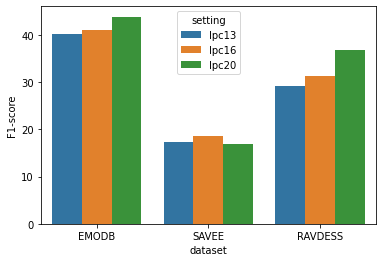

In [38]:
x = sns.barplot(x="dataset", y="F1-score", hue="setting", data=df_result3)

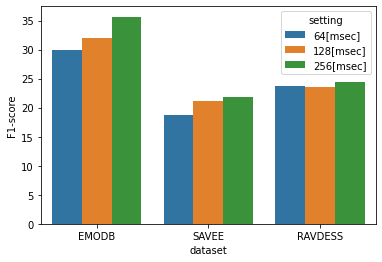

In [39]:
x = sns.barplot(x="dataset", y="F1-score", hue="setting", data=df_result2)

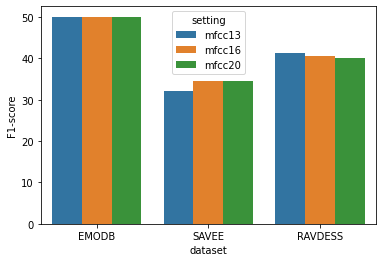

In [40]:
x = sns.barplot(x="dataset", y="F1-score", hue="setting", data=df_result1)

# Combining features

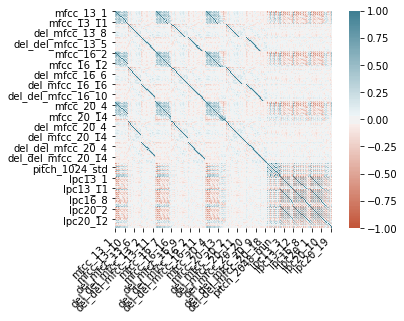

In [16]:
corr = df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

# EMODB

In [49]:
mfccs = [16]
pitches = [4096]
lpcs = [20]
interesting_emo = [4,2,6,0]
folds = [('03','08'),#male, female 
         ('10','09'),
         ('11','13'),
         ('12','14'),
         ('15','16'),
         ('03','09'),
         ('10','13'),
         ('11','14'),
         ('12','16'),
         ('15','08')
        ]

path = 'E:\\Coding_projects\\Speech_Emotion_Recognition\\EMODB'
Data = read_data(path)
dict_mfcc, dict_ptich, dict_lpc = getColFeature(mfccs,pitches,lpcs)
dict_feature = {'feature': dict_mfcc[16]+dict_ptich[4096]+dict_lpc[20]}
print(dict_feature)
# Overall Performance
result = compare_models(folds, dict_feature, interesting_emo, 'mfcc')
for i in result:
    print(i)
    for j in result[i]:
        print(result[i][j])
print('-----------------------------------------')

speaker: 03
speaker: 08
speaker: 09
speaker: 10
speaker: 11
speaker: 12
speaker: 13
speaker: 14
speaker: 15
speaker: 16
{'feature': ['mfcc_16_1', 'mfcc_16_2', 'mfcc_16_3', 'mfcc_16_4', 'mfcc_16_5', 'mfcc_16_6', 'mfcc_16_7', 'mfcc_16_8', 'mfcc_16_9', 'mfcc_16_10', 'mfcc_16_11', 'mfcc_16_12', 'mfcc_16_13', 'mfcc_16_14', 'mfcc_16_15', 'mfcc_16_16', 'del_mfcc_16_1', 'del_mfcc_16_2', 'del_mfcc_16_3', 'del_mfcc_16_4', 'del_mfcc_16_5', 'del_mfcc_16_6', 'del_mfcc_16_7', 'del_mfcc_16_8', 'del_mfcc_16_9', 'del_mfcc_16_10', 'del_mfcc_16_11', 'del_mfcc_16_12', 'del_mfcc_16_13', 'del_mfcc_16_14', 'del_mfcc_16_15', 'del_mfcc_16_16', 'del_del_mfcc_16_1', 'del_del_mfcc_16_2', 'del_del_mfcc_16_3', 'del_del_mfcc_16_4', 'del_del_mfcc_16_5', 'del_del_mfcc_16_6', 'del_del_mfcc_16_7', 'del_del_mfcc_16_8', 'del_del_mfcc_16_9', 'del_del_mfcc_16_10', 'del_del_mfcc_16_11', 'del_del_mfcc_16_12', 'del_del_mfcc_16_13', 'del_del_mfcc_16_14', 'del_del_mfcc_16_15', 'del_del_mfcc_16_16', 'pitch_4096_mean', 'pitch_4096

# SAVEE

In [50]:
mfccs = [16]
pitches = [4096]
lpcs = [20]
interesting_emo = [4,2,6,0]
folds = [('JK'),#male, female 
         ('JE'),
         ('DC'),
         ('KL')
        ]

path = 'E:\\Coding_projects\\Speech_Emotion_Recognition\\SAVEE'
Data = read_data(path)
dict_mfcc, dict_ptich, dict_lpc = getColFeature(mfccs,pitches,lpcs)
dict_feature = {'feature': dict_mfcc[16]+dict_ptich[4096]+dict_lpc[20]}
# compare mfcc
result = compare_models(folds, dict_feature,interesting_emo, 'mfcc')
for i in result:
    print(i)
    for j in result[i]:
        print(result[i][j])
print('-----------------------------------------')

speaker: DC
speaker: JE
speaker: JK
speaker: KL
fold_num: 0
(360, 72)
(360,)
(120, 72)
(120,)
fold_num: 1
(360, 72)
(360,)
(120, 72)
(120,)
fold_num: 2
(360, 72)
(360,)
(120, 72)
(120,)
fold_num: 3
(360, 72)
(360,)
(120, 72)
(120,)
logistic
[0.3041912  0.33411074 0.32535768 0.28217244 0.2627722  0.23693377
 0.23517473]
forest
[0.29494026 0.32244442 0.33094623 0.31573507 0.31819708 0.31819708]
svm
[0.27208285 0.27208285 0.27208285 0.33395751 0.33125181 0.33526348
 0.33526348]
-----------------------------------------


# RAVDESS

In [51]:
mfccs = [16]
pitches = [16384]
lpcs = [20]
interesting_emo = [0,3,1,4]
folds = [('01','02'),#male, female 
         ('03','04'),
         ('05','06'),
         ('07','08'),
         ('09','10'),
         ('11','12'),
         ('13','14'),
         ('15','16'),
         ('17','18'),
         ('19','20'),
         ('21','22'),
         ('23','24')
        ]
path = 'E:\\Coding_projects\\Speech_Emotion_Recognition\\RAVDESS'
Data = read_data(path)
dict_mfcc, dict_ptich, dict_lpc = getColFeature(mfccs,pitches,lpcs)
dict_feature = {'feature': dict_mfcc[16]+dict_ptich[16384]+dict_lpc[20]}
# compare mfcc
result = compare_models(folds, dict_feature,interesting_emo, 'mfcc')
for i in result:
    print(i)
    for j in result[i]:
        print(result[i][j])
print('-----------------------------------------')

speaker: 01
speaker: 02
speaker: 03
speaker: 04
speaker: 05
speaker: 06
speaker: 07
speaker: 08
speaker: 09
speaker: 10
speaker: 11
speaker: 12
speaker: 13
speaker: 14
speaker: 15
speaker: 16
speaker: 17
speaker: 18
speaker: 19
speaker: 20
speaker: 21
speaker: 22
speaker: 23
speaker: 24
fold_num: 0
(1320, 72)
(1320,)
(120, 72)
(120,)
fold_num: 1
(1320, 72)
(1320,)
(120, 72)
(120,)
fold_num: 2
(1320, 72)
(1320,)
(120, 72)
(120,)
fold_num: 3
(1320, 72)
(1320,)
(120, 72)
(120,)
fold_num: 4
(1320, 72)
(1320,)
(120, 72)
(120,)
fold_num: 5
(1320, 72)
(1320,)
(120, 72)
(120,)
fold_num: 6
(1320, 72)
(1320,)
(120, 72)
(120,)
fold_num: 7
(1320, 72)
(1320,)
(120, 72)
(120,)
fold_num: 8
(1320, 72)
(1320,)
(120, 72)
(120,)
fold_num: 9
(1320, 72)
(1320,)
(120, 72)
(120,)
fold_num: 10
(1320, 72)
(1320,)
(120, 72)
(120,)
fold_num: 11
(1320, 72)
(1320,)
(120, 72)
(120,)
logistic
[0.34606577 0.37134789 0.38969288 0.40461449 0.40212596 0.39725326
 0.40170165]
forest
[0.28746302 0.31237342 0.33332778 0.33